In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from Utils import plotMetricsGraphComparison # Custom plotting method to compare metrics between models

sb.set() # set the default Seaborn style for graphics

In [2]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

In [3]:
X_train = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test = pd.read_csv('Data/X_test.csv')[columns]
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

test_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

### Decision Tree Classification Model (Without Bagging)

In [4]:
from sklearn.tree import DecisionTreeClassifier
decisionTreeModel = DecisionTreeClassifier(random_state=47)
decisionTreeModel.fit(X_train, Y_train)

# Predict the output based on our training and testing dataset
Y_train_pred = decisionTreeModel.predict(X_train)
Y_test_pred = decisionTreeModel.predict(X_test)

In [5]:
test_metric = {
    "Classification Model": "Decision Tree",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.763332,0.422724,0.411415,0.416993


### Applying Bagging to Improve Classification Performance

Previously we made use of decision tree as one of our classification techniques, a possible improvement is we can actually apply bagging. Bagging is an ensembling technique that involves training multiple models independently with subsets of the data, and then combining the prediction. This technique can help improve accuracy and also reduce variance.

To improve the decision tree model via bagging, we can make use of the Random Forest model.

### Random Forest Classification Model (A bagging model that improves over Decision Tree)

In [6]:
from sklearn.ensemble import RandomForestClassifier

randomForestModel = RandomForestClassifier(random_state=47)
randomForestModel.fit(X_train, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred = randomForestModel.predict(X_train)
Y_test_pred = randomForestModel.predict(X_test)

Train and Test Data Confusion Matrix:


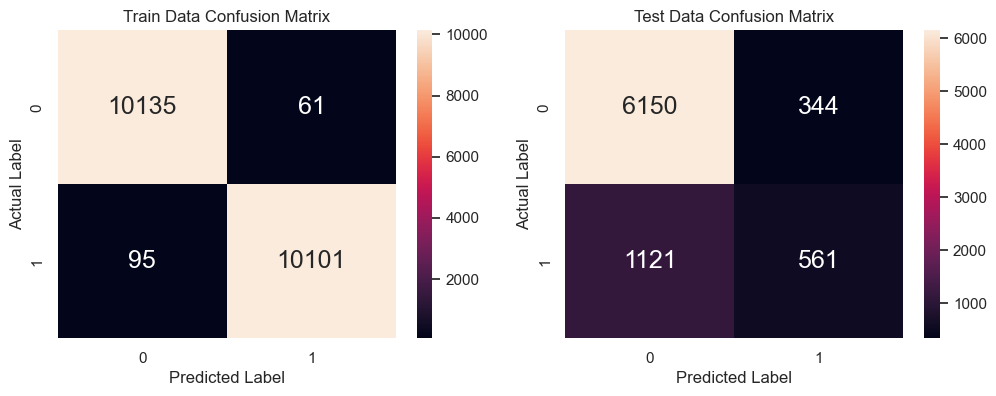

In [7]:
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(Y_train, Y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
axes[0].set_title('Train Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

sb.heatmap(confusion_matrix(Y_test, Y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[1].set_title('Test Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('Actual Label')

print("Train and Test Data Confusion Matrix:")

In [8]:
test_metric = {
    "Classification Model": "Random Forest",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

# Save to overall metrics dataframe for comparison later
test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", test_metric["Accuracy"])
print("Precision \t:", test_metric["Precision"])
print("Recall \t\t:", test_metric["Recall"])
print("F1 Score \t:", test_metric["F1 Score"])

**Test Set Metrics**
Accuracy 	: 0.8208170254403131
Precision 	: 0.6198895027624309
Recall 		: 0.3335315101070155
F1 Score 	: 0.43370699652106687


In [9]:
test_metrics.sort_values(by=['Accuracy'], ascending=True,inplace=True)
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.763332,0.422724,0.411415,0.416993
1,Random Forest,0.820817,0.619890,0.333532,0.433707


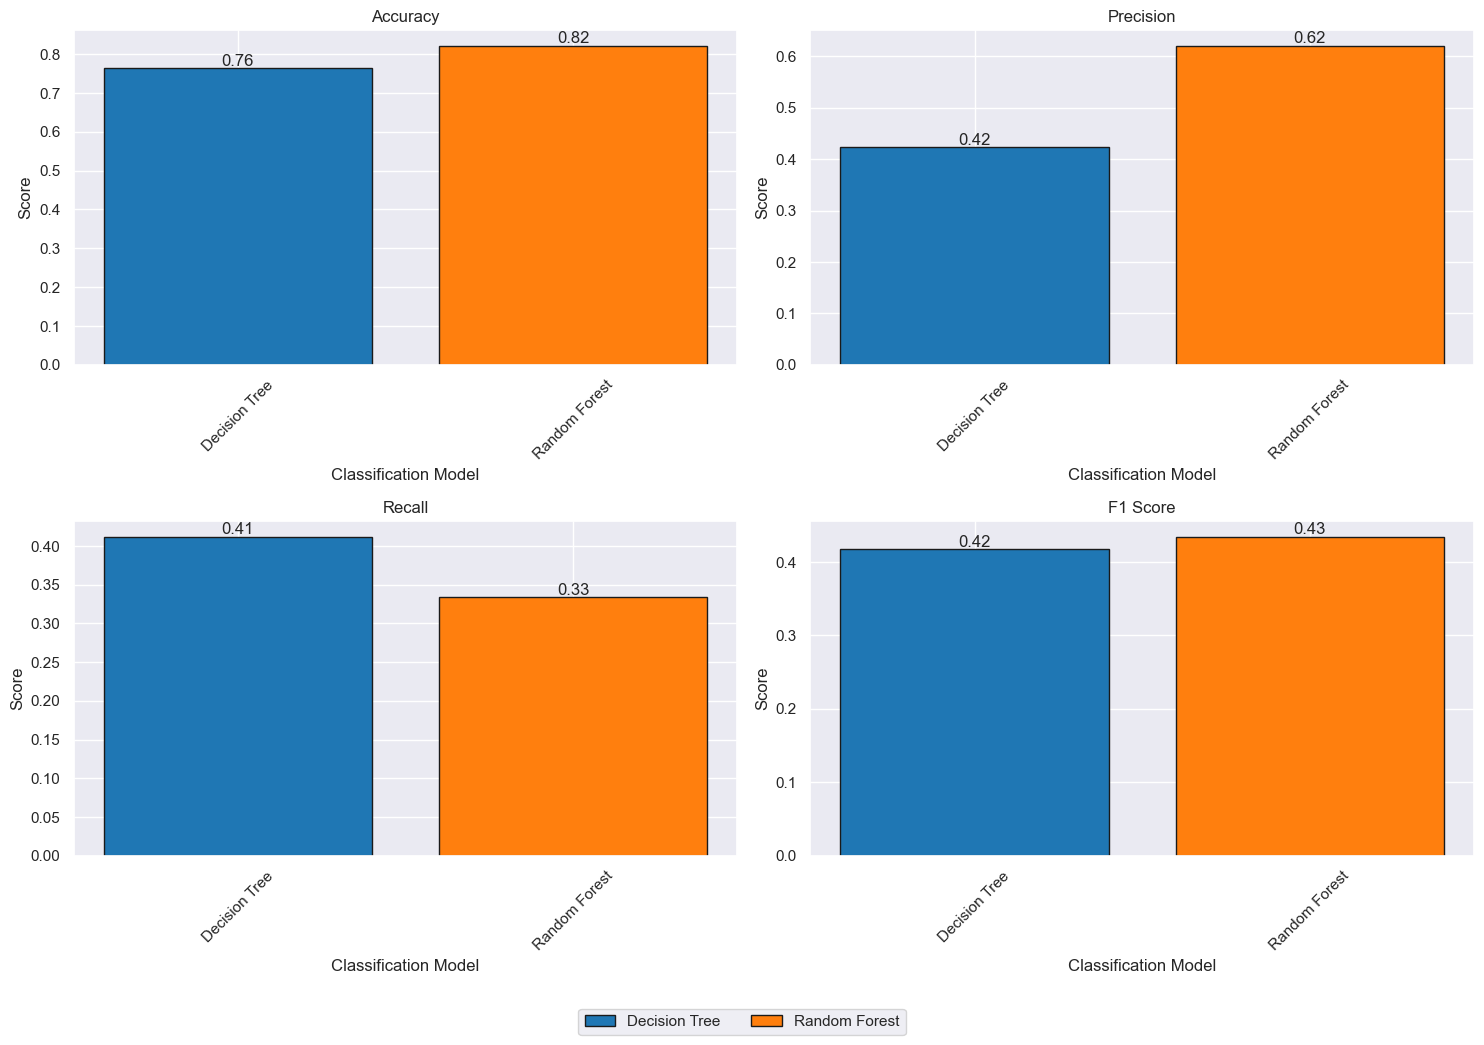

In [10]:
plotMetricsGraphComparison(test_metrics)

After using bagging to improve Decision Tree, we can actually see Random Forest has the highest accuracy and precision out of all the current classification models and significantly improved the results as compared to the decision tree model.

However, the low recall score is a concern as compared to the decision tree model, it means out of all the actual positive labels, it only correctly identified a low percentage amount. This could be due to reasons such as data imbalances, the data features used for training, to improve this, we will explore feature engineering to create new attributes.

Feature engineering notebook can be found at: [Feature Engineering Notebook](./Feature%20Engineering.ipynb).


### Load Data After Feature Engineering

In [11]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 105)
Test Set  : (8176, 1) (8176, 105)


### Perform Feature Selection on Feature Engineered Data

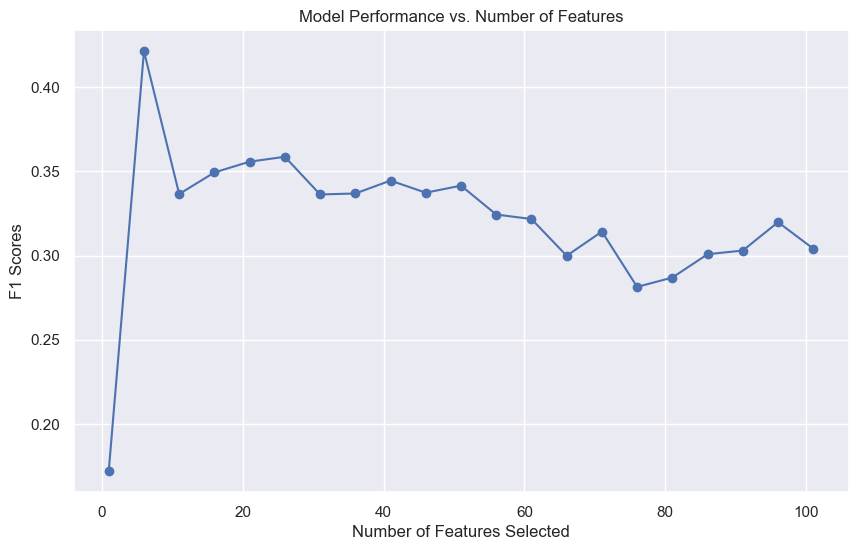

Best F1 Score:  0.42136279926335174
Best Number Of Features:  6


In [12]:
from FeatureSelectionUtils import feature_selection_using_rfe_on_f1score

RandomForestModel = RandomForestClassifier(random_state=47)
featuresForBestRunUsingF1Score = feature_selection_using_rfe_on_f1score(RandomForestModel, X_train, Y_train, X_test, Y_test)

In [13]:
# Selected Features
featuresForBestRunUsingF1Score

,attribute,selected,ranking
0,traveller_type_adults_only,False,81
1,traveller_type_children_only,False,91
2,traveller_type_mixed,False,77
3,stay_type_hour_room,False,94
4,stay_type_mixed,False,27
...,...,...,...
100,no_of_special_requests_scaled,True,1
101,lead_time_scaled,True,1
102,avg_price_per_room_scaled,True,1
103,arrival_month_sin,False,4


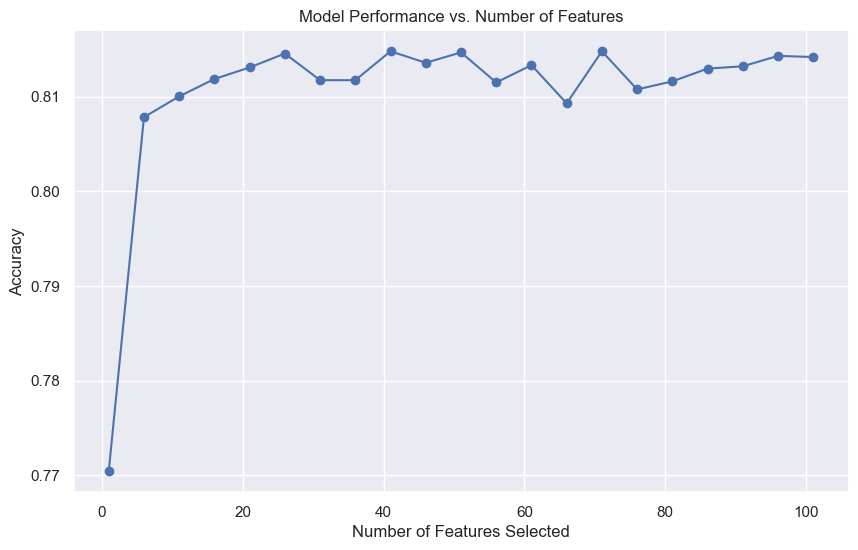

Best Accuracy:  0.8148238747553816
Best Number Of Features:  41


In [14]:
from FeatureSelectionUtils import feature_selection_using_rfe_on_accuracy

RandomForestModel = RandomForestClassifier(random_state=47)
featuresForBestRunUsingAccuracy = feature_selection_using_rfe_on_accuracy(RandomForestModel, X_train, Y_train, X_test, Y_test)

In [15]:
# Selected Features
featuresForBestRunUsingAccuracy

,attribute,selected,ranking
0,traveller_type_adults_only,False,46
1,traveller_type_children_only,False,56
2,traveller_type_mixed,False,42
3,stay_type_hour_room,False,59
4,stay_type_mixed,True,1
...,...,...,...
100,no_of_special_requests_scaled,True,1
101,lead_time_scaled,True,1
102,avg_price_per_room_scaled,True,1
103,arrival_month_sin,True,1
